<a href="https://colab.research.google.com/github/jerryk42/SemEval-Food-Hazard-Detection-Challenge/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [20]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  # Import tqdm for progress bars
import matplotlib.pyplot as plt
from google.colab import drive

In [21]:
# Mounting on google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Configuration of the model
config = {
    'max_len': 256,
    'batch_size': 16,
    'learning_rate': 0.00005,
    'epochs': 100,
    'model_name': "dmis-lab/biobert-base-cased-v1.1"  # BioBERT model name
}


In [23]:
# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [24]:
# URL of the raw file
url = "https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(df.head())

   Unnamed: 0  year  month  day country                             title  \
0           0  1994      1    7      us  Recall Notification: FSIS-024-94   
1           1  1994      3   10      us  Recall Notification: FSIS-033-94   
2           2  1994      3   28      us  Recall Notification: FSIS-014-94   
3           3  1994      4    3      us  Recall Notification: FSIS-009-94   
4           4  1994      7    1      us  Recall Notification: FSIS-001-94   

                                                text hazard-category  \
0  Case Number: 024-94   \n            Date Opene...      biological   
1  Case Number: 033-94   \n            Date Opene...      biological   
2  Case Number: 014-94   \n            Date Opene...      biological   
3  Case Number: 009-94   \n            Date Opene...  foreign bodies   
4  Case Number: 001-94   \n            Date Opene...  foreign bodies   

               product-category                  hazard  \
0  meat, egg and dairy products  listeria mon

In [25]:
# Drop the first column
df = df.drop(df.columns[0], axis=1)

In [26]:
# Check the structure of the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              5082 non-null   int64 
 1   month             5082 non-null   int64 
 2   day               5082 non-null   int64 
 3   country           5082 non-null   object
 4   title             5082 non-null   object
 5   text              5082 non-null   object
 6   hazard-category   5082 non-null   object
 7   product-category  5082 non-null   object
 8   hazard            5082 non-null   object
 9   product           5082 non-null   object
dtypes: int64(3), object(7)
memory usage: 397.2+ KB
None


In [27]:
# Custom Dataset for Text Data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [28]:
# Function to clean text (title or text) and remove stopwords
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = ' '.join(text.split())
    return text


In [29]:
# Load tokenizer for Microsoft PubMedBERT model
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Assuming df is your DataFrame
df['text'] = df['text'].apply(clean_text)


In [32]:
# Define relevant features and targets
features = ['year', 'month', 'day', 'country']
subtask1 = ['hazard-category','product-category']
subtask2 = ['hazard','product']


In [33]:
# Encode target labels to numeric values
label_encoders = {}
for target in subtask1 + subtask2:
    le = LabelEncoder()
    df[target] = le.fit_transform(df[target])
    label_encoders[target] = le


In [34]:
# Prepare data for both title and text
def prepare_data(text_column):
    X = df[features + [text_column]]
    y_subtask1 = df[subtask1]
    y_subtask2 = df[subtask2]

    data_splits = {}
    for target in subtask1 + subtask2:
        X_train, X_test, y_train, y_test = train_test_split(
            X, df[target], test_size=0.1, random_state=42
        )

        # Reset indices to ensure matching
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        data_splits[target] = (X_train, X_test, y_train, y_test)

    return data_splits


In [35]:
# Prepare data for title and text
title_splits = prepare_data('title')
text_splits = prepare_data('text')


In [36]:
def train_and_evaluate_nn(data_splits, targets, model_type='title', early_stopping_patience=6, lr_reduce_factor=0.05):
    f1_scores = []  # List to store F1 scores for each task

    for target in targets:
        print(f"\nStarting training for task: {target}")  # Print task message

        X_train, X_test, y_train, y_test = data_splits[target]

        # Prepare text data using the tokenizer
        if model_type == 'title':
            texts_train = X_train['title'].values
            texts_test = X_test['title'].values
        else:
            texts_train = X_train['text'].values
            texts_test = X_test['text'].values

        # Create DataLoader for training and testing
        train_dataset = TextDataset(texts_train, y_train, tokenizer, config['max_len'])
        test_dataset = TextDataset(texts_test, y_test, tokenizer, config['max_len'])

        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

        # Model setup
        num_labels = len(label_encoders[target].classes_)
        model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=num_labels).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_reduce_factor, patience=3, verbose=True)
        criterion = nn.CrossEntropyLoss()

        # Training process
        model.train()
        best_loss = float('inf')
        early_stop_counter = 0

        for epoch in range(config['epochs']):
            print(f"Epoch {epoch+1}/{config['epochs']} - Training: {target}")
            progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", total=len(train_loader), leave=True)
            epoch_loss = 0.0

            for batch in progress_bar:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].squeeze(1).to(device)
                attention_mask = batch['attention_mask'].squeeze(1).to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())

            # Average loss for the epoch
            avg_epoch_loss = epoch_loss / len(train_loader)
            print(f"Average Training Loss for Epoch {epoch+1}: {avg_epoch_loss}")

            # Evaluate on the test set to compute validation loss
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch['input_ids'].squeeze(1).to(device)
                    attention_mask = batch['attention_mask'].squeeze(1).to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(test_loader)
            print(f"Validation Loss after Epoch {epoch+1}: {avg_val_loss}")

            # Step the scheduler with the validation loss
            scheduler.step(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                early_stop_counter = 0
                torch.save(model.state_dict(), f"best_model_{target}.pt")  # Save the best model
            else:
                early_stop_counter += 1
                print(f"Early stopping counter: {early_stop_counter}/{early_stopping_patience}")

            if early_stop_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

        # Load the best model for evaluation
        model.load_state_dict(torch.load(f"best_model_{target}.pt"))

        # Evaluation process
        print(f"Evaluating model for task: {target}")
        model.eval()
        y_preds = []
        y_true = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating", total=len(test_loader), leave=True):
                input_ids = batch['input_ids'].squeeze(1).to(device)
                attention_mask = batch['attention_mask'].squeeze(1).to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs.logits, dim=1)
                y_preds.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        # Decode labels back to original categories using the label encoder
        decoded_preds = label_encoders[target].inverse_transform(y_preds)
        decoded_true = label_encoders[target].inverse_transform(y_true)

        # Calculate F1 score for the task
        f1 = f1_score(decoded_true, decoded_preds, average='weighted')
        f1_scores.append(f1)
        print(f"F1-Score for {target}: {f1}")

        # Print classification report
        print(f"Classification Report for {target}:\n")
        print(classification_report(decoded_true, decoded_preds, zero_division=0))

    return f1_scores  # Return the list of F1 scores for plotting


In [37]:
# Train and evaluate for both title and text
print("\nTraining and Evaluating for Title Tasks:")
title_f1_scores = train_and_evaluate_nn(title_splits, subtask1 + subtask2, model_type='title')


Training and Evaluating for Title Tasks:

Starting training for task: hazard-category


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: hazard-category


Training Epoch 1: 100%|██████████| 286/286 [01:24<00:00,  3.39it/s, loss=0.731]


Average Training Loss for Epoch 1: 0.8391710806481697
Validation Loss after Epoch 1: 0.684822328388691
Epoch 2/100 - Training: hazard-category


Training Epoch 2: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.0742]


Average Training Loss for Epoch 2: 0.5030099867185304
Validation Loss after Epoch 2: 0.5898981164209545
Epoch 3/100 - Training: hazard-category


Training Epoch 3: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.409]


Average Training Loss for Epoch 3: 0.3212648796412599
Validation Loss after Epoch 3: 0.6839247900061309
Early stopping counter: 1/6
Epoch 4/100 - Training: hazard-category


Training Epoch 4: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0393]


Average Training Loss for Epoch 4: 0.212170943227056
Validation Loss after Epoch 4: 0.7780294450931251
Early stopping counter: 2/6
Epoch 5/100 - Training: hazard-category


Training Epoch 5: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0884]


Average Training Loss for Epoch 5: 0.1455102684171675
Validation Loss after Epoch 5: 0.7540938910096884
Early stopping counter: 3/6
Epoch 6/100 - Training: hazard-category


Training Epoch 6: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.296]


Average Training Loss for Epoch 6: 0.1036541857561292
Validation Loss after Epoch 6: 0.7857046816498041
Early stopping counter: 4/6
Epoch 7/100 - Training: hazard-category


Training Epoch 7: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.104]


Average Training Loss for Epoch 7: 0.061231792153842696
Validation Loss after Epoch 7: 0.7417516740970314
Early stopping counter: 5/6
Epoch 8/100 - Training: hazard-category


Training Epoch 8: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.00567]


Average Training Loss for Epoch 8: 0.04181492382618175
Validation Loss after Epoch 8: 0.7439211782766506
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-36-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard-category


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.03it/s]


F1-Score for hazard-category: 0.82792968672088
Classification Report for hazard-category:

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       188
           1       0.85      0.93      0.89       171
           2       0.81      0.60      0.69        35
           3       0.00      0.00      0.00         5
           4       0.77      0.84      0.80        58
           5       0.78      0.64      0.71        28
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.89      0.53      0.67        15
           9       0.00      0.00      0.00         5

    accuracy                           0.84       509
   macro avg       0.50      0.45      0.47       509
weighted avg       0.82      0.84      0.83       509


Starting training for task: product-category


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: product-category


Training Epoch 1: 100%|██████████| 286/286 [01:24<00:00,  3.38it/s, loss=1.09]


Average Training Loss for Epoch 1: 1.7992793848881354
Validation Loss after Epoch 1: 1.149048862978816
Epoch 2/100 - Training: product-category


Training Epoch 2: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.705]


Average Training Loss for Epoch 2: 0.9122850159248272
Validation Loss after Epoch 2: 0.9277553297579288
Epoch 3/100 - Training: product-category


Training Epoch 3: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0575]


Average Training Loss for Epoch 3: 0.5123526228370366
Validation Loss after Epoch 3: 0.9759407956153154
Early stopping counter: 1/6
Epoch 4/100 - Training: product-category


Training Epoch 4: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=1.1]


Average Training Loss for Epoch 4: 0.28581313383798085
Validation Loss after Epoch 4: 1.0119524272158742
Early stopping counter: 2/6
Epoch 5/100 - Training: product-category


Training Epoch 5: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0478]


Average Training Loss for Epoch 5: 0.16936148974679774
Validation Loss after Epoch 5: 1.1206264458596706
Early stopping counter: 3/6
Epoch 6/100 - Training: product-category


Training Epoch 6: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0629]


Average Training Loss for Epoch 6: 0.11000564838336273
Validation Loss after Epoch 6: 1.2314193919301033
Early stopping counter: 4/6
Epoch 7/100 - Training: product-category


Training Epoch 7: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0244]


Average Training Loss for Epoch 7: 0.05184709920932155
Validation Loss after Epoch 7: 1.194928282406181
Early stopping counter: 5/6
Epoch 8/100 - Training: product-category


Training Epoch 8: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.00747]


Average Training Loss for Epoch 8: 0.03526347557935942
Validation Loss after Epoch 8: 1.2035068394616246
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-36-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product-category


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.04it/s]


F1-Score for product-category: 0.7263395818998133
Classification Report for product-category:

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.61      0.81      0.70        54
           2       0.75      0.83      0.79        29
           3       0.67      0.20      0.31        20
           4       0.41      0.64      0.50        11
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.78      0.80      0.79        56
          10       0.44      0.44      0.44         9
          12       0.97      0.88      0.92        33
          13       0.82      0.95      0.88       131
          14       0.87      0.81      0.84        16
          15       0.78      0.84      0.81        37
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: hazard


Training Epoch 1: 100%|██████████| 286/286 [01:24<00:00,  3.38it/s, loss=3.35]


Average Training Loss for Epoch 1: 2.8727127117710514
Validation Loss after Epoch 1: 2.055177252739668
Epoch 2/100 - Training: hazard


Training Epoch 2: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=2.47]


Average Training Loss for Epoch 2: 1.8492886586622759
Validation Loss after Epoch 2: 1.7318320292979479
Epoch 3/100 - Training: hazard


Training Epoch 3: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.893]


Average Training Loss for Epoch 3: 1.3893939102446282
Validation Loss after Epoch 3: 1.6055078636854887
Epoch 4/100 - Training: hazard


Training Epoch 4: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.637]


Average Training Loss for Epoch 4: 1.0161088964530638
Validation Loss after Epoch 4: 1.5895892567932606
Epoch 5/100 - Training: hazard


Training Epoch 5: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=1.46]


Average Training Loss for Epoch 5: 0.7316830027587973
Validation Loss after Epoch 5: 1.6311842147260904
Early stopping counter: 1/6
Epoch 6/100 - Training: hazard


Training Epoch 6: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.182]


Average Training Loss for Epoch 6: 0.536114669528666
Validation Loss after Epoch 6: 1.5707994624972343
Epoch 7/100 - Training: hazard


Training Epoch 7: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.457]


Average Training Loss for Epoch 7: 0.3821847282897134
Validation Loss after Epoch 7: 1.660772131755948
Early stopping counter: 1/6
Epoch 8/100 - Training: hazard


Training Epoch 8: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.364]


Average Training Loss for Epoch 8: 0.2686733654993293
Validation Loss after Epoch 8: 1.6875372752547264
Early stopping counter: 2/6
Epoch 9/100 - Training: hazard


Training Epoch 9: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.119]


Average Training Loss for Epoch 9: 0.18680512819478248
Validation Loss after Epoch 9: 1.6799706406891346
Early stopping counter: 3/6
Epoch 10/100 - Training: hazard


Training Epoch 10: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.016]


Average Training Loss for Epoch 10: 0.14128560437397522
Validation Loss after Epoch 10: 1.7588777542114258
Early stopping counter: 4/6
Epoch 11/100 - Training: hazard


Training Epoch 11: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0189]


Average Training Loss for Epoch 11: 0.09252552018611582
Validation Loss after Epoch 11: 1.7114620264619589
Early stopping counter: 5/6
Epoch 12/100 - Training: hazard


Training Epoch 12: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.0894]


Average Training Loss for Epoch 12: 0.07581622189829139
Validation Loss after Epoch 12: 1.7032967396080494
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-36-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.00it/s]


F1-Score for hazard: 0.6359264217601279
Classification Report for hazard:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         3
           5       0.30      0.75      0.43         4
           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.40      0.40      0.40         5
          15       0.00      0.00      0.00         1
          17       0.48      0.59      0.53        17
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          22       1.00      1.00      1.00         3
          23       0.00      0.00      0.00         1
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: product


Training Epoch 1: 100%|██████████| 286/286 [01:24<00:00,  3.37it/s, loss=6.16]


Average Training Loss for Epoch 1: 6.336150942982494
Validation Loss after Epoch 1: 5.858946770429611
Epoch 2/100 - Training: product


Training Epoch 2: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=5.51]


Average Training Loss for Epoch 2: 5.31364850230984
Validation Loss after Epoch 2: 5.0575438886880875
Epoch 3/100 - Training: product


Training Epoch 3: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=5.03]


Average Training Loss for Epoch 3: 4.367346717761113
Validation Loss after Epoch 3: 4.550716556608677
Epoch 4/100 - Training: product


Training Epoch 4: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=3.08]


Average Training Loss for Epoch 4: 3.591390492199184
Validation Loss after Epoch 4: 4.177453272044659
Epoch 5/100 - Training: product


Training Epoch 5: 100%|██████████| 286/286 [01:23<00:00,  3.42it/s, loss=3.96]


Average Training Loss for Epoch 5: 2.926560097224229
Validation Loss after Epoch 5: 3.9132177382707596
Epoch 6/100 - Training: product


Training Epoch 6: 100%|██████████| 286/286 [01:23<00:00,  3.42it/s, loss=1.44]


Average Training Loss for Epoch 6: 2.351120855007972
Validation Loss after Epoch 6: 3.729815222322941
Epoch 7/100 - Training: product


Training Epoch 7: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=2.1]


Average Training Loss for Epoch 7: 1.865076778651951
Validation Loss after Epoch 7: 3.590485967695713
Epoch 8/100 - Training: product


Training Epoch 8: 100%|██████████| 286/286 [01:23<00:00,  3.42it/s, loss=1.58]


Average Training Loss for Epoch 8: 1.4840326442585126
Validation Loss after Epoch 8: 3.4700793847441673
Epoch 9/100 - Training: product


Training Epoch 9: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=1.04]


Average Training Loss for Epoch 9: 1.1671310571002793
Validation Loss after Epoch 9: 3.4302622452378273
Epoch 10/100 - Training: product


Training Epoch 10: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.812]


Average Training Loss for Epoch 10: 0.9232274226166985
Validation Loss after Epoch 10: 3.3886151015758514
Epoch 11/100 - Training: product


Training Epoch 11: 100%|██████████| 286/286 [01:23<00:00,  3.42it/s, loss=0.457]


Average Training Loss for Epoch 11: 0.7360304694075684
Validation Loss after Epoch 11: 3.367245577275753
Epoch 12/100 - Training: product


Training Epoch 12: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.387]


Average Training Loss for Epoch 12: 0.5815050220572865
Validation Loss after Epoch 12: 3.325780987739563
Epoch 13/100 - Training: product


Training Epoch 13: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.764]


Average Training Loss for Epoch 13: 0.47527359827206683
Validation Loss after Epoch 13: 3.366954382508993
Early stopping counter: 1/6
Epoch 14/100 - Training: product


Training Epoch 14: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.524]


Average Training Loss for Epoch 14: 0.3809935844314474
Validation Loss after Epoch 14: 3.3358466029167175
Early stopping counter: 2/6
Epoch 15/100 - Training: product


Training Epoch 15: 100%|██████████| 286/286 [01:23<00:00,  3.42it/s, loss=0.147]


Average Training Loss for Epoch 15: 0.30307016265090114
Validation Loss after Epoch 15: 3.344312012195587
Early stopping counter: 3/6
Epoch 16/100 - Training: product


Training Epoch 16: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.229]


Average Training Loss for Epoch 16: 0.23932039076006495
Validation Loss after Epoch 16: 3.364182762801647
Early stopping counter: 4/6
Epoch 17/100 - Training: product


Training Epoch 17: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.168]


Average Training Loss for Epoch 17: 0.18319651020130703
Validation Loss after Epoch 17: 3.3618218451738358
Early stopping counter: 5/6
Epoch 18/100 - Training: product


Training Epoch 18: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.179]


Average Training Loss for Epoch 18: 0.1685072622633168
Validation Loss after Epoch 18: 3.36287335306406
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-36-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.02it/s]

F1-Score for product: 0.4678291770016206
Classification Report for product:

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           2       1.00      0.60      0.75         5
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          13       0.75      1.00      0.86         3
          19       1.00      1.00      1.00         2
          20       0.50      1.00      0.67         1
          22       1.00      1.00      1.00         1
          24       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          30       0.00      0.00      0.00         0
          31       0.00      0.00      0.00         1
          35       0.00      0.00      0.00         1
    

In [38]:
print("\nTraining and Evaluating for Text Tasks:")
text_f1_scores = train_and_evaluate_nn(text_splits, subtask1 + subtask2, model_type='text')



Training and Evaluating for Text Tasks:

Starting training for task: hazard-category


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: hazard-category


Training Epoch 1: 100%|██████████| 286/286 [01:36<00:00,  2.97it/s, loss=0.599]


Average Training Loss for Epoch 1: 0.6290615882880829
Validation Loss after Epoch 1: 0.3245128197595477
Epoch 2/100 - Training: hazard-category


Training Epoch 2: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.186]


Average Training Loss for Epoch 2: 0.25798709008035126
Validation Loss after Epoch 2: 0.2419404195388779
Epoch 3/100 - Training: hazard-category


Training Epoch 3: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0574]


Average Training Loss for Epoch 3: 0.17730917175092012
Validation Loss after Epoch 3: 0.22245623762137257
Epoch 4/100 - Training: hazard-category


Training Epoch 4: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0288]


Average Training Loss for Epoch 4: 0.13641293596645648
Validation Loss after Epoch 4: 0.21702212584204972
Epoch 5/100 - Training: hazard-category


Training Epoch 5: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0429]


Average Training Loss for Epoch 5: 0.1009764209734862
Validation Loss after Epoch 5: 0.23921011027414352
Early stopping counter: 1/6
Epoch 6/100 - Training: hazard-category


Training Epoch 6: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.0262]


Average Training Loss for Epoch 6: 0.10650748891554043
Validation Loss after Epoch 6: 0.2276633754663635
Early stopping counter: 2/6
Epoch 7/100 - Training: hazard-category


Training Epoch 7: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.13]


Average Training Loss for Epoch 7: 0.11438136742453553
Validation Loss after Epoch 7: 0.22027365372923668
Early stopping counter: 3/6
Epoch 8/100 - Training: hazard-category


Training Epoch 8: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0308]


Average Training Loss for Epoch 8: 0.08077404431923833
Validation Loss after Epoch 8: 0.21204899798613042
Epoch 9/100 - Training: hazard-category


Training Epoch 9: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.00206]


Average Training Loss for Epoch 9: 0.047193714117523856
Validation Loss after Epoch 9: 0.26783676442937576
Early stopping counter: 1/6
Epoch 10/100 - Training: hazard-category


Training Epoch 10: 100%|██████████| 286/286 [01:34<00:00,  3.02it/s, loss=0.00276]


Average Training Loss for Epoch 10: 0.03686159319741736
Validation Loss after Epoch 10: 0.2671974256809335
Early stopping counter: 2/6
Epoch 11/100 - Training: hazard-category


Training Epoch 11: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.00962]


Average Training Loss for Epoch 11: 0.03482082267548283
Validation Loss after Epoch 11: 0.2514030852835276
Early stopping counter: 3/6
Epoch 12/100 - Training: hazard-category


Training Epoch 12: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.00362]


Average Training Loss for Epoch 12: 0.038772959444693035
Validation Loss after Epoch 12: 0.2742101990879746
Early stopping counter: 4/6
Epoch 13/100 - Training: hazard-category


Training Epoch 13: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.00635]


Average Training Loss for Epoch 13: 0.01418877428542445
Validation Loss after Epoch 13: 0.2723349534862791
Early stopping counter: 5/6
Epoch 14/100 - Training: hazard-category


Training Epoch 14: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.00191]


Average Training Loss for Epoch 14: 0.01009624600703535
Validation Loss after Epoch 14: 0.27530865275184624
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-36-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard-category


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  9.06it/s]


F1-Score for hazard-category: 0.9417192745216745
Classification Report for hazard-category:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       188
           1       0.98      0.99      0.99       171
           2       0.92      1.00      0.96        35
           3       0.50      0.20      0.29         5
           4       0.98      1.00      0.99        58
           5       0.69      0.79      0.73        28
           6       0.00      0.00      0.00         1
           7       0.60      1.00      0.75         3
           8       0.90      0.60      0.72        15
           9       1.00      0.60      0.75         5

    accuracy                           0.94       509
   macro avg       0.75      0.71      0.71       509
weighted avg       0.94      0.94      0.94       509


Starting training for task: product-category


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: product-category


Training Epoch 1: 100%|██████████| 286/286 [01:36<00:00,  2.98it/s, loss=2.05]


Average Training Loss for Epoch 1: 2.165630628595819
Validation Loss after Epoch 1: 1.860517218708992
Epoch 2/100 - Training: product-category


Training Epoch 2: 100%|██████████| 286/286 [01:34<00:00,  3.02it/s, loss=1.15]


Average Training Loss for Epoch 2: 1.3998593020064014
Validation Loss after Epoch 2: 1.3338965829461813
Epoch 3/100 - Training: product-category


Training Epoch 3: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=1.86]


Average Training Loss for Epoch 3: 0.9339450276814975
Validation Loss after Epoch 3: 1.0170307783409953
Epoch 4/100 - Training: product-category


Training Epoch 4: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.266]


Average Training Loss for Epoch 4: 0.626533744505027
Validation Loss after Epoch 4: 0.9829536005854607
Epoch 5/100 - Training: product-category


Training Epoch 5: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=1.5]


Average Training Loss for Epoch 5: 0.43524510621816126
Validation Loss after Epoch 5: 1.05213917279616
Early stopping counter: 1/6
Epoch 6/100 - Training: product-category


Training Epoch 6: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.184]


Average Training Loss for Epoch 6: 0.30570460863124865
Validation Loss after Epoch 6: 1.21366445440799
Early stopping counter: 2/6
Epoch 7/100 - Training: product-category


Training Epoch 7: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.243]


Average Training Loss for Epoch 7: 0.21236594111521864
Validation Loss after Epoch 7: 1.2107336707413197
Early stopping counter: 3/6
Epoch 8/100 - Training: product-category


Training Epoch 8: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.0126]


Average Training Loss for Epoch 8: 0.14322448491568227
Validation Loss after Epoch 8: 1.3553482294082642
Early stopping counter: 4/6
Epoch 9/100 - Training: product-category


Training Epoch 9: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.00882]


Average Training Loss for Epoch 9: 0.09298340198779283
Validation Loss after Epoch 9: 1.2641982247587293
Early stopping counter: 5/6
Epoch 10/100 - Training: product-category


Training Epoch 10: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0219]


Average Training Loss for Epoch 10: 0.06074646849452251
Validation Loss after Epoch 10: 1.2643121511209756
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-36-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product-category


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s]


F1-Score for product-category: 0.7221893294931326
Classification Report for product-category:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.73      0.67      0.70        54
           2       0.69      0.76      0.72        29
           3       0.35      0.40      0.37        20
           4       0.88      0.64      0.74        11
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.79      0.79      0.79        56
          10       0.30      0.67      0.41         9
          12       0.97      0.91      0.94        33
          13       0.86      0.88      0.87       131
          14       1.00      0.81      0.90        16
          15       0.74      0.54      0.62        37
          16       0.00      0.00      0.00         1
          17       0.75      1.00      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: hazard


Training Epoch 1: 100%|██████████| 286/286 [01:36<00:00,  2.97it/s, loss=1.14]


Average Training Loss for Epoch 1: 2.69183080419377
Validation Loss after Epoch 1: 1.464539966545999
Epoch 2/100 - Training: hazard


Training Epoch 2: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=1.53]


Average Training Loss for Epoch 2: 1.2450363259840678
Validation Loss after Epoch 2: 0.9808227133471519
Epoch 3/100 - Training: hazard


Training Epoch 3: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.737]


Average Training Loss for Epoch 3: 0.8678210198983446
Validation Loss after Epoch 3: 0.7922879987163469
Epoch 4/100 - Training: hazard


Training Epoch 4: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.203]


Average Training Loss for Epoch 4: 0.6374109331388157
Validation Loss after Epoch 4: 0.7032566380221397
Epoch 5/100 - Training: hazard


Training Epoch 5: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.518]


Average Training Loss for Epoch 5: 0.48657346523360356
Validation Loss after Epoch 5: 0.7177542063873261
Early stopping counter: 1/6
Epoch 6/100 - Training: hazard


Training Epoch 6: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.24]


Average Training Loss for Epoch 6: 0.38531388214730716
Validation Loss after Epoch 6: 0.6464546208735555
Epoch 7/100 - Training: hazard


Training Epoch 7: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.332]


Average Training Loss for Epoch 7: 0.29670669366377633
Validation Loss after Epoch 7: 0.6383900495711714
Epoch 8/100 - Training: hazard


Training Epoch 8: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.189]


Average Training Loss for Epoch 8: 0.22553408688416224
Validation Loss after Epoch 8: 0.6486862966557965
Early stopping counter: 1/6
Epoch 9/100 - Training: hazard


Training Epoch 9: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0304]


Average Training Loss for Epoch 9: 0.1636092308778446
Validation Loss after Epoch 9: 0.6387864230782725
Early stopping counter: 2/6
Epoch 10/100 - Training: hazard


Training Epoch 10: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0941]


Average Training Loss for Epoch 10: 0.11838461182542614
Validation Loss after Epoch 10: 0.6703560353198554
Early stopping counter: 3/6
Epoch 11/100 - Training: hazard


Training Epoch 11: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.301]


Average Training Loss for Epoch 11: 0.095334633106978
Validation Loss after Epoch 11: 0.7027192693785764
Early stopping counter: 4/6
Epoch 12/100 - Training: hazard


Training Epoch 12: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0152]


Average Training Loss for Epoch 12: 0.06393971808183078
Validation Loss after Epoch 12: 0.6931241928832605
Early stopping counter: 5/6
Epoch 13/100 - Training: hazard


Training Epoch 13: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0163]


Average Training Loss for Epoch 13: 0.04876733647327271
Validation Loss after Epoch 13: 0.6935719783214154
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-36-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s]


F1-Score for hazard: 0.8500440569622675
Classification Report for hazard:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         3
           5       0.80      1.00      0.89         4
           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         1
          13       1.00      0.50      0.67         2
          14       1.00      0.80      0.89         5
          15       0.00      0.00      0.00         1
          17       0.77      1.00      0.87        17
          18       0.00      0.00      0.00         1
          19       0.50      1.00      0.67         1
          22       1.00      1.00      1.00         3
          23       0.00      0.00      0.00         1
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: product


Training Epoch 1: 100%|██████████| 286/286 [01:36<00:00,  2.98it/s, loss=6.37]


Average Training Loss for Epoch 1: 6.341293988527951
Validation Loss after Epoch 1: 5.876046866178513
Epoch 2/100 - Training: product


Training Epoch 2: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=3.99]


Average Training Loss for Epoch 2: 5.338552538331572
Validation Loss after Epoch 2: 5.083326235413551
Epoch 3/100 - Training: product


Training Epoch 3: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=4.71]


Average Training Loss for Epoch 3: 4.426661391358276
Validation Loss after Epoch 3: 4.601574383676052
Epoch 4/100 - Training: product


Training Epoch 4: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=4.21]


Average Training Loss for Epoch 4: 3.6530434526763598
Validation Loss after Epoch 4: 4.230145379900932
Epoch 5/100 - Training: product


Training Epoch 5: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=3.14]


Average Training Loss for Epoch 5: 2.97862971120781
Validation Loss after Epoch 5: 3.8918039351701736
Epoch 6/100 - Training: product


Training Epoch 6: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=2.43]


Average Training Loss for Epoch 6: 2.4054010093628944
Validation Loss after Epoch 6: 3.7032704800367355
Epoch 7/100 - Training: product


Training Epoch 7: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=1.12]


Average Training Loss for Epoch 7: 1.906824576062756
Validation Loss after Epoch 7: 3.569550931453705
Epoch 8/100 - Training: product


Training Epoch 8: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=1.92]


Average Training Loss for Epoch 8: 1.5080041301834
Validation Loss after Epoch 8: 3.499046929180622
Epoch 9/100 - Training: product


Training Epoch 9: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.943]


Average Training Loss for Epoch 9: 1.1763537681915543
Validation Loss after Epoch 9: 3.4084729105234146
Epoch 10/100 - Training: product


Training Epoch 10: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.78]


Average Training Loss for Epoch 10: 0.9211796951460671
Validation Loss after Epoch 10: 3.3559048399329185
Epoch 11/100 - Training: product


Training Epoch 11: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.627]


Average Training Loss for Epoch 11: 0.7241443922886481
Validation Loss after Epoch 11: 3.333665654063225
Epoch 12/100 - Training: product


Training Epoch 12: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=1.17]


Average Training Loss for Epoch 12: 0.5708555967084594
Validation Loss after Epoch 12: 3.324141375720501
Epoch 13/100 - Training: product


Training Epoch 13: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.164]


Average Training Loss for Epoch 13: 0.45136316975096724
Validation Loss after Epoch 13: 3.3047217205166817
Epoch 14/100 - Training: product


Training Epoch 14: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.277]


Average Training Loss for Epoch 14: 0.35751560227489554
Validation Loss after Epoch 14: 3.35725224763155
Early stopping counter: 1/6
Epoch 15/100 - Training: product


Training Epoch 15: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.574]


Average Training Loss for Epoch 15: 0.2825933822228775
Validation Loss after Epoch 15: 3.3241336792707443
Early stopping counter: 2/6
Epoch 16/100 - Training: product


Training Epoch 16: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.303]


Average Training Loss for Epoch 16: 0.22404296279370367
Validation Loss after Epoch 16: 3.3500266522169113
Early stopping counter: 3/6
Epoch 17/100 - Training: product


Training Epoch 17: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0301]


Average Training Loss for Epoch 17: 0.17322348949818553
Validation Loss after Epoch 17: 3.3947231397032738
Early stopping counter: 4/6
Epoch 18/100 - Training: product


Training Epoch 18: 100%|██████████| 286/286 [01:35<00:00,  2.99it/s, loss=0.12]


Average Training Loss for Epoch 18: 0.13276964594069476
Validation Loss after Epoch 18: 3.3838233798742294
Early stopping counter: 5/6
Epoch 19/100 - Training: product


Training Epoch 19: 100%|██████████| 286/286 [01:35<00:00,  2.99it/s, loss=0.0709]


Average Training Loss for Epoch 19: 0.12142692039349487
Validation Loss after Epoch 19: 3.3809075579047203
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-36-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s]


F1-Score for product: 0.4647634090165141
Classification Report for product:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           2       0.75      0.60      0.67         5
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          13       1.00      0.67      0.80         3
          19       0.67      1.00      0.80         2
          20       0.33      1.00      0.50         1
          22       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          31       0.00      0.00      0.00         1
          35       0.00      0.00      0.00         1
          38       1.00      1.00      1.00         2
          41       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         1
    

In [40]:
# Create DataFrames for F1 scores for title and text
f1_scores_title_df = pd.DataFrame({
    'Task': subtask1 + subtask2,
    'F1-Score': title_f1_scores
})

f1_scores_text_df = pd.DataFrame({
    'Task': subtask1 + subtask2,
    'F1-Score': text_f1_scores
})


Collected F1-Scores for Title-Focused Classification:
               Task  F1-Score
0   hazard-category  0.827930
1  product-category  0.726340
2            hazard  0.635926
3           product  0.467829

Collected F1-Scores for Text-Focused Classification:
               Task  F1-Score
0   hazard-category  0.941719
1  product-category  0.722189
2            hazard  0.850044
3           product  0.464763


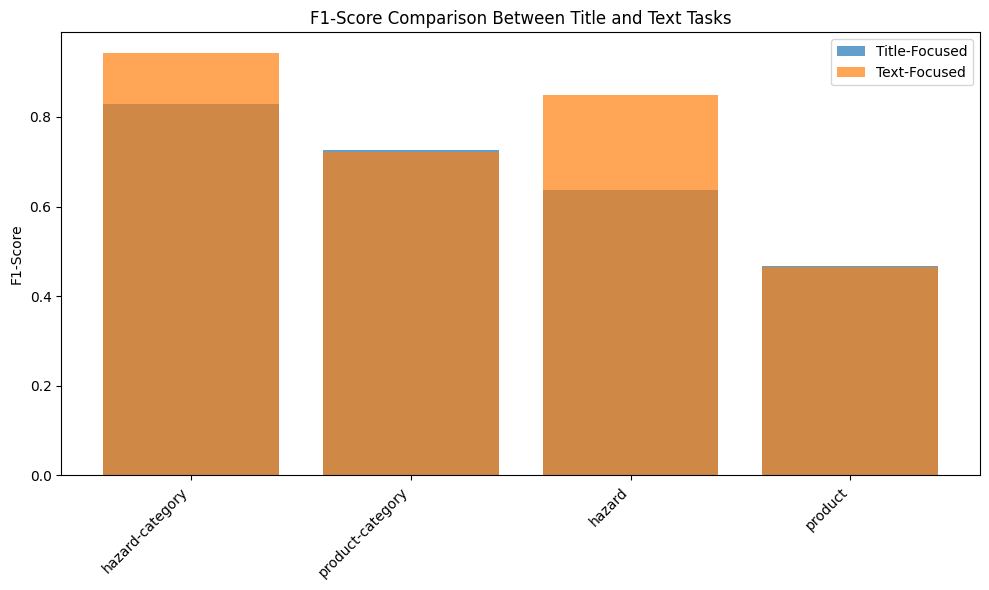

In [39]:
# Create DataFrames for F1 scores for title and text
f1_scores_title_df = pd.DataFrame({
    'Task': subtask1 + subtask2,
    'F1-Score': title_f1_scores
})

f1_scores_text_df = pd.DataFrame({
    'Task': subtask1 + subtask2,
    'F1-Score': text_f1_scores
})

# Print the collected F1-scores for title
print("\nCollected F1-Scores for Title-Focused Classification:")
print(f1_scores_title_df)

# Print the collected F1-scores for text
print("\nCollected F1-Scores for Text-Focused Classification:")
print(f1_scores_text_df)

# Plot F1-scores for visual comparison
plt.figure(figsize=(10, 6))
plt.bar(f1_scores_title_df['Task'], f1_scores_title_df['F1-Score'], alpha=0.7, label='Title-Focused')
plt.bar(f1_scores_text_df['Task'], f1_scores_text_df['F1-Score'], alpha=0.7, label='Text-Focused')
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison Between Title and Text Tasks")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
